<a href="https://colab.research.google.com/github/jvribeirocostard/proke/blob/main/caderno_fraude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit-plot


In [ ]:
import torch
from torch import sigmoid
from torch import tensor
from torch import nn
import torchvision
from sklearn.model_selection import train_test_split
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
import scikitplot as skplt
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Funções

In [ ]:
def col_str_to_num(column,df):
    """
    Transforma os dados categóricos de uma coluna em dados numéricos
    """
    val = len(df[column].value_counts()) # Number of distinct valueswithin a column stored in the val variable

    x1 = df[column].values # Column values in an array
    x2 = x1.tolist() # Transforming the array into a list
    unic_list = list(dict.fromkeys(x2)) # Putting the distinct values inside a list

    list_ = []
    for i in range(val): # Enumerating the number of distinct values in a list
        list_.append(i)


    for c in list_:
        df[column] = df[column].replace(unic_list[c],c)
        print(f"column {column} => Exchanging {unic_list[c]} for {c}")
    return df[column]


def line():
    print("="*100)

def dataset_compl(df):
    """
    Transforms the categorical data of an entire dataset into numeric data
    """
    df_obj = df.select_dtypes(include='object').columns.tolist()

    line()
    for column_name in df_obj:
        col_str_to_num(column_name,df)
        df[column_name] = pd.to_numeric(df[column_name],errors = 'coerce')
        line()
    return df

## Dataset A

In [ ]:
df_a = pd.read_csv('DatasetA.csv')
df_a

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1.0,0.0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
136330,11,CASH_OUT,210797.87,C895247865,157365.74,0.00,C1350789239,9460720.59,9671518.46,0.0,0.0
136331,11,CASH_IN,169337.27,C1835291495,2372.00,171709.27,C876369005,0.00,0.00,0.0,0.0
136332,11,CASH_IN,277705.23,C1509818117,10768.00,288473.23,C1079160246,0.00,0.00,0.0,0.0
136333,11,PAYMENT,28755.04,C1857400501,50455.00,21699.96,M940600631,0.00,0.00,0.0,0.0


In [ ]:
df_a = df_a[['step', 'type', 'amount','oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest','isFlaggedFraud', 'isFraud']]
df_a = dataset_compl(df_a)
df_a

column type => Exchanging PAYMENT for 0
column type => Exchanging TRANSFER for 1
column type => Exchanging CASH_OUT for 2
column type => Exchanging DEBIT for 3
column type => Exchanging CASH_IN for 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFlaggedFraud,isFraud
0,1,0,9839.64,170136.00,160296.36,0.00,0.00,0.0,0.0
1,1,0,1864.28,21249.00,19384.72,0.00,0.00,0.0,0.0
2,1,1,181.00,181.00,0.00,0.00,0.00,0.0,1.0
3,1,2,181.00,181.00,0.00,21182.00,0.00,0.0,1.0
4,1,0,11668.14,41554.00,29885.86,0.00,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...,...
136330,11,2,210797.87,157365.74,0.00,9460720.59,9671518.46,0.0,0.0
136331,11,4,169337.27,2372.00,171709.27,0.00,0.00,0.0,0.0
136332,11,4,277705.23,10768.00,288473.23,0.00,0.00,0.0,0.0
136333,11,0,28755.04,50455.00,21699.96,0.00,0.00,0.0,0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


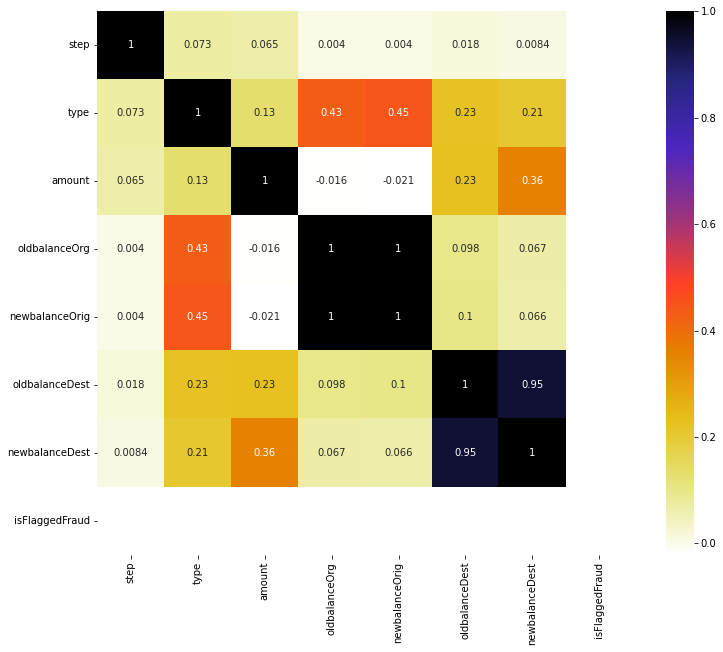

In [ ]:
X = df_a.drop('isFraud',1)

y = df_a['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = X_train.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

In [ ]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
corr_features = correlation(X_train, 0.7)
len(set(corr_features))

2

In [ ]:
corr_features

{'newbalanceDest', 'newbalanceOrig'}

In [ ]:
X_train.drop(corr_features,axis=1)
X_test.drop(corr_features,axis=1)

,step,type,amount,oldbalanceOrg,oldbalanceDest,isFlaggedFraud
3287,2,0,11816.56,55201.00,0.00,0.0
129383,11,3,547.98,1158277.75,9750.00,0.0
53908,9,4,339907.05,68975.00,143140.52,0.0
127787,11,0,28853.49,68028.00,0.00,0.0
72384,9,2,348760.44,602.00,0.00,0.0
...,...,...,...,...,...,...
53339,9,2,157295.14,0.00,4695796.84,0.0
110766,11,2,168535.09,0.00,1356730.26,0.0
119280,11,2,78878.17,259.00,35922.36,0.0
56705,9,2,9024.20,51131.00,0.00,0.0


## Dataset B

In [ ]:
df_b = pd.read_csv('DatasetB.csv')
df_b.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


### Normalização de Dados

In [ ]:
features = ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
X = df_b.loc[:,features].values
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=30)
Components = pca.fit_transform(X)
DfPCA_b = pd.DataFrame(data = Components, columns = features)

DfPCA_b['Class'] = df_b['Class']
DfPCA_b.head()

ValueError: ignored

### Feature Selection

In [ ]:
X = DfPCA_b.drop(['Class'],axis=1)
y = DfPCA_b['Class']

f_classif = SelectKBest(k=10)
fit = f_classif.fit(X,y)
features = fit.transform(X)

cols = fit.get_support(indices=True)
X_V = X.iloc[:,cols]
X_V

NameError: ignored

### Balanceamento dos dados (Vale a pena nesse caso?)

### Resultado sem balancear as classes

In [ ]:
df_b['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9992    0.9998    0.9995     56864
           1     0.8462    0.5612    0.6748        98

    accuracy                         0.9991     56962
   macro avg     0.9227    0.7805    0.8372     56962
weighted avg     0.9990    0.9991    0.9990     56962

Acurácia: 0.9991

AUC: 0.7805



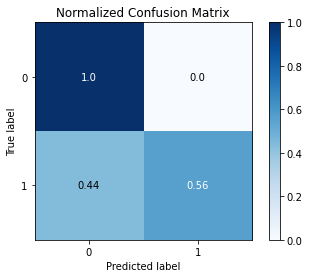

In [ ]:
# dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_V,y,test_size=0.2,random_state=42)

# instanciar e treinar um modelo de Regressão Logística semo balanceamento
model = LogisticRegression()
model.fit(X_train, y_train)

# fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

### Resultado Balanceando as classes

In [ ]:
# usar técnica under-sampling
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X_train, y_train)

# ver o balanceamento das classes
print(pd.Series(y_res).value_counts())

0    394
1    394
Name: Class, dtype: int64


Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9998    0.9877    0.9937     56864
           1     0.1097    0.8776    0.1950        98

    accuracy                         0.9875     56962
   macro avg     0.5547    0.9326    0.5944     56962
weighted avg     0.9983    0.9875    0.9923     56962

Acurácia: 0.9875

AUC: 0.9326



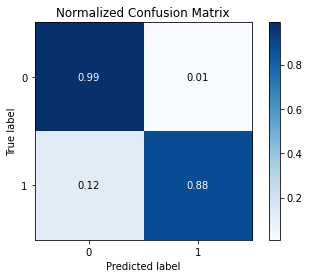

In [ ]:
# instanciar e treinar um modelo de Regressão Logística
model_res = LogisticRegression()
model_res.fit(X_res, y_res)

# fazer as previsões em cima dos dados de teste
y_pred_res = model_res.predict(X_test)
y_proba_res = model_res.predict_proba(X_test)

# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred_res, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_res, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred_res)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred_res)))